# Neuron

In [ ]:
# | default_exp nn

In [ ]:
#| export
from nanograd.core import Value
from graphviz import Digraph
import random
import numpy as np
from abc import abstractmethod
from typing import List, Union, Any, Tuple
import math

In [ ]:
class Module:

    @abstractmethod
    def parameters(self) -> List[Value]:
        return []
    
    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0
    
    def backward(self):
        for p in self.parameters():
            p.backward()


In [ ]:
# | export


class Neuron(Module):
    """
    A simple neuron which has trainable weights from each input and a bias term.
    """
    def __init__(
        self,
        nin: int,  # number of inputs
    ) -> None:
        self.w = [Value(random.uniform(-1, 1), label=f"w{i}") for i in range(nin)]
        self.b = Value(random.uniform(-1, 1), label="b")

    def __call__(self, x):
        assert len(x) == len(self.w)
        x = [Value(_x) if not isinstance(_x, Value) else _x for _x in x]
        act = sum((wi*xi for wi, xi in zip(self.w, x)) , self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return list(self.w) + [self.b]
    

In [ ]:
# | export


class Layer(Module):
    """
    A layer of neurons. Each neuron has the same number of inputs. Number of neurons required depends on the number of outputs.
    """

    def __init__(
        self,
        nin: int,  # number of inputs
        nout: int,  # number of outputs
        label: str = "", # label for the layer
    ) -> None:
        self.neurons = [Neuron(nin) for _ in range(nout)]
        self.nin = nin
        self.nout = nout
        self.label = label

    def __call__(self, x):
        return [neuron(x) for neuron in self.neurons]

    @staticmethod
    def number_to_color(num):
        # Scale the number to a value between 0 and 8
        scaled_num = min(max(math.floor(num / 10 * 8),0),7)
        # Get the color from the greens9 color scheme
        dylgn9 = ["#a50026", "#d73027", "#f46d43", "#fdae61", "#fee08b", "#d9ef8b", "#a6d96a", "#66bd63", "#1a9850"]
        return dylgn9[scaled_num]

    def draw_layer(
        self,
        inputs: Union[List[int], Any] = None,
        dot: Digraph = None,
        return_dot_only: bool = True,
    ):
        dot = Digraph(format="svg", graph_attr={"rankdir": "LR"}) if dot is None else dot
        if inputs is None:
            inputs = [Value(random.uniform(-1, 1), label=f"x_{i}") for i in range(self.nin)]
        bias_label = str(id(f"bias_{self.label}"))
        bias = dot.node(bias_label, label=f"bias", shape="record")
        op_node_ids = []
        for i, neuron in enumerate(self.neurons):
            dot.edge(bias_label, str(id(neuron)), label=f"b_{i}", color=self.number_to_color(int((neuron.b.data + 1)*5)), labeltooltip=f"{neuron.b}")
            dot.node(str(id(neuron)), label=f"layer: {self.label} | neuron: {i}",  shape="record")
            op_node_ids.append(id(neuron))
            for j, ip in enumerate(inputs):
                input_src = str(ip.label) if isinstance(ip, Value) else str(ip)
                color = self.number_to_color(int((neuron.w[j].data + 1)*5))
                dot.edge(input_src, str(id(neuron)), label=f"w_{j}_{i}", color=color, labeltooltip=f"{neuron.w[j]}")
        if return_dot_only:
            return dot
        return dot, op_node_ids

    def parameters(self):
        params = []
        for neuron in self.neurons:
            params += neuron.parameters()
        return params
    

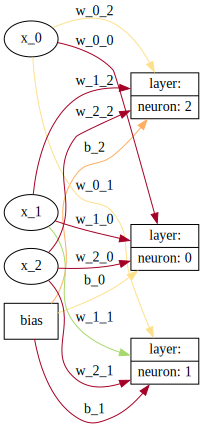

In [ ]:
Layer(3, 3).draw_layer()

In [ ]:
# | export


class MLP(Module):
    """
    A milti layer-preceptron. Each layer is fully connected to the next layer.
    """
    def __init__(
        self,
        nin: int, # number of inputs
        nouts: List[int], # list of number of outputs for each layer
    ) -> None:
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1], i+1) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def draw_nn(self):
        dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})
        inputs = [Value(random.uniform(-1, 1), label=f"x_{i}") for i in range(self.layers[0].nin)]
        for i, layer in enumerate(self.layers):
            dot, inputs = layer.draw_layer(inputs, dot, return_dot_only=False)
        return dot
    
    def parameters(self):
        params = []
        for layer in self.layers:
            params += layer.parameters()
        return params
    


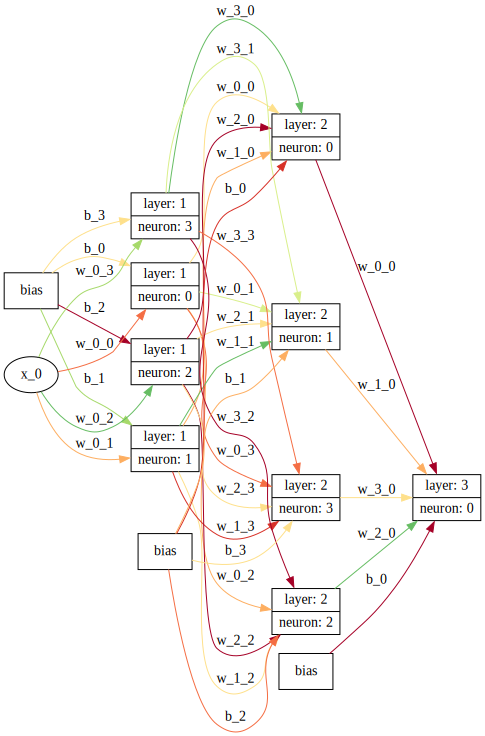

In [ ]:
import math

# Generate 10 samples of a sine wave
num_samples = 10
samples = [(i, 1 if math.sin(i)>0 else -1) for i in np.arange(-5, 5, 0.1)]

xs, ys = zip(*samples)
xs, ys = list(xs), list(ys)   

model = MLP(1, [4, 4, 1])
model.draw_nn()